In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy
import statsmodels.api as s
from sklearn import metrics

import pdb

In [2]:
sub_list = ['AC_newepoch','AM', 'BB','CM','CR','GG','HA','IB','JM','JR','KK','KT','MC','MH','NF','SB','SG','SOG','TL','ZZ']
data_dir = f'/lab_data/behrmannlab/vlad/pepdoc/results_ex1' #read in the file; first value is the file name
curr_dir = f'/user_data/vayzenbe/GitHub_Repos/pepdoc' #CHANGE AS NEEEDED CAUSE ITS FOR VLAAAD
fig_dir = f'{curr_dir}/figures' #where to save the figures
results_dir = f'{curr_dir}/results' #where to save the results

# bin_size = 1 
categories = ['tool','nontool','bird','insect']
labels = np.asanyarray([0]*5 + [1]*5 + [2]*5 + [3]*5) #creates labels for data



pre_stim = 50 #ms before stim onset
stim_end = 300 #ms when stim goes off
post_stim = 500 #ms after stim offset
bin_length = 4 #length of each bin in ms
bin_size = 1 #how many bins were averaged over; 1 = no averaging; 5 = average over 20 ms

#calculate start window for analysis given the bin size and length
start_window = pre_stim - (bin_length*(bin_size-1)) 
#calculate the onset point of the stimulus in the dataframe given the start window and bin length
stim_onset = int(start_window/bin_length)+1 
stim_offset = int(stim_end/bin_length)+stim_onset-1
timepoints = list(range(-start_window, post_stim, bin_length)) #134 20 ms bins


#### Count channels

In [5]:
"""Count how many channels are missing on average"""

channel_perc = []
for sub in sub_list:
    for category in categories[0:1]: #loop through categories
        
        
        curr_df = pd.read_csv(f'/{data_dir}/{sub}/{category}s/{category}{1}.tsv' , sep='\t')#read in the file; first value is the file name

        channel_perc.append(1-curr_df.shape[0]/256)

print('missing channels:',np.mean(channel_perc))

missing channels: 0.1517578125


#### ERP Plots

(0, 'dorsal') max time: 230
(1, 'ventral') max time: 250


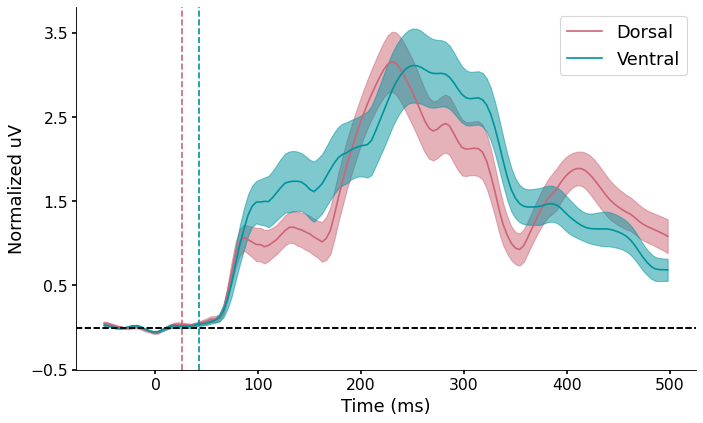

In [6]:
'''
Plot ERPs for each ROI with shading
'''
rois = ['ventral', 'dorsal']
roi_names = ['Ventral', 'Dorsal']
colors = ['#CC6677','#00949e']

rois = ['dorsal', 'ventral']
roi_names = ['Dorsal','Ventral']
#colors = ['#00949e','#CC6677']
onsets = [26,42]

plt.figure(figsize=(10, 6), dpi=80)
for roi in enumerate(rois):
    roi_erp = np.abs(np.load(f'{results_dir}/erp/{roi[1]}_mean_ts.npy'))

        
    pre_stim = roi_erp[:,:stim_onset] #pull out the pre-stimulus data
    pre_stim = np.mean(pre_stim, axis=1) #average across prestim timepoints

    roi_norm = roi_erp - pre_stim[:,None]#subtract the prestimulus average from each timepoint
    
    roi_mean = np.mean(roi_norm, axis=0)
    maxtime = np.where(roi_mean == np.max(roi_mean))[0][0]
    print(f'{roi} max time:', ((maxtime *bin_length)-start_window))
    
    
    sem = np.std(roi_norm, ddof=1, axis =0) / np.sqrt(roi_norm.shape[0])

    plt.plot(timepoints, roi_mean, label=roi[1].capitalize(), color = colors[roi[0]]) #...plot the data, add error bars to mat plot lib, use standard error of the mean to add., there is a package called psypy to do this (psyplot - SEM)
    plt.axhline(y=0, color='k', linestyle='--')
    
    plt.axvline(x=onsets[roi[0]], color=colors[roi[0]], linestyle='--')
    plt.fill_between(timepoints, roi_mean-sem, roi_mean+sem,alpha=0.5, color = colors[roi[0]])
    plt.legend(fontsize=16)

    plt.xlabel('Time (ms)',fontsize=16)
    plt.ylabel('Normalized uV',fontsize=16)
    
    plt.xticks(fontsize= 14)
    plt.yticks(fontsize= 14)
    plt.ylim(-.5,3.8)

    ax = plt.gca()
    ax.xaxis.set_tick_params(width=1.5)
    ax.yaxis.set_tick_params(width=1.5)

    start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(start, end, 1))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    #plt.show()
    
    plt.savefig(f'{fig_dir}/erp_plot.png', dpi=300)


In [7]:

rois = ['dorsal','ventral']
for roi in rois:
    roi_erp = np.abs(np.load(f'{results_dir}/erp/{roi}_mean_ts.npy'))

        
    pre_stim = roi_erp[:,:stim_onset] #pull out the pre-stimulus data
    pre_stim = np.mean(pre_stim, axis=1) #average across prestim timepoints

    roi_norm = roi_erp - pre_stim[:,None]#subtract the prestimulus average from each timepoint
    
    sig_ts = []
    for time in range(0, roi_norm.shape[1]):
        p_val = stats.ttest_1samp((roi_norm[:,time]), 0, axis = 0, alternative='greater')
        sig_ts.append(p_val[1])

    np.save(f'{results_dir}/erp/{roi}_sig_ts.npy', sig_ts)

(0, 'dorsal') 26
(1, 'ventral') 42


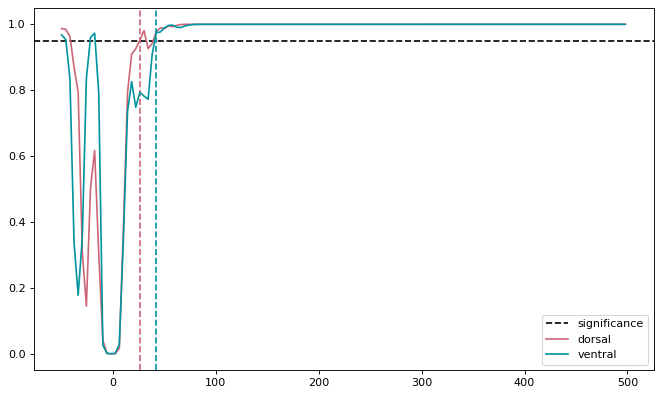

In [8]:
'''
Plot significance time series
'''

rois = ['dorsal','ventral']
line_color =  ['#CC6677','#00949e']
alpha_level = .95
plt.figure(figsize=(10, 6), dpi=80)
plt.axhline(alpha_level, color = 'k', label='significance', linestyle='--')
for roi in enumerate(rois):
    sig_data = 1-np.load(f'{results_dir}/erp/{roi[1]}_sig_ts.npy')
    onset = np.min(np.where(sig_data[stim_onset:] >= alpha_level))+stim_onset
    onset = ((onset *bin_length)-start_window)
    plt.plot(timepoints, sig_data, label = roi[1], color = line_color[roi[0]])
    plt.axvline(onset,  linestyle='--', color = line_color[roi[0]])
    plt.legend()
    print(roi, onset)





#### Test ERP onset

In [9]:
'''
Boot strap participant data and extract onset
'''

rois = ['dorsal','ventral']
iter = 1000

boot_df = pd.DataFrame()
for roi in rois:
    roi_erp = np.abs(np.load(f'{results_dir}/erp/{roi}_mean_ts.npy'))
    pre_stim = roi_erp[:,:stim_onset] #pull out the pre-stimulus data
    pre_stim = np.mean(pre_stim, axis=1) #average across prestim timepoints

    roi_norm = roi_erp - pre_stim[:,None]#subtract the prestimulus average from each timepoint
    
    roi_norm = roi_norm[:,stim_onset:]
    erp_data = pd.DataFrame(roi_norm) #convert to dataframe because it has a good resampling function
    erp_boot = []
    sub_counts = np.zeros((1,erp_data.shape[1]))

    for ii in range(0,iter):
        
        #resample the sub decode data with replacement
        sub_sample = erp_data.sample(erp_data.shape[0],replace = True, random_state=ii)
        
        #convert it back to a numpy array
        sub_sample = sub_sample.to_numpy() 
        
        #calculate the bootstrap sample mean
        sig_boot = []
        
        #only add values if they are significant two timepoints in arow
        sig_consistent = []
        
        sig_ts = []
        for time in range(0,sub_sample.shape[1]):
            p_val= stats.ttest_1samp(sub_sample[:,time], 0, axis = 0, alternative='greater')
            
            #append the p-value for every time point
            sig_ts.append(p_val[1])  


            #mark timepoints that are above chance for at least two timepoints in a row
            if time > 0:

                if sig_ts[time] <= .05 and sig_ts[time-1] <=.05:
                    sig_consistent.append(1)
                else:
                    sig_consistent.append(0)

        #reconvert p-value list into a numpy array
        sig_ts = np.asanyarray(sig_ts)

        #reconvert consistent list into a numpy array
        sig_consistent = np.asanyarray(sig_consistent)
            
        #find the the first time point that is below change (0.05)
        #np.where simply returns the indices (i.e., spots in an array), that meet some condition
        #i'm simply grabbing the first value of that list, which corresponds to the first time point above chance
        try:
            sig_onset = np.where(sig_consistent ==1,)[0][0]
        except:
            sig_onset= erp_data.shape[1]
        
        
        
        sub_counts[0,np.where(sig_ts <=.05)[0]] += 1
        
        #if d_onset == 1:
        #    pdb.set_trace()
        
        #convert to the actual time point
        sig_onset = (sig_onset *4)

        #add the onset value from the resample to a list
        erp_boot.append(sig_onset)
    
    boot_df[roi] = erp_boot

boot_df.to_csv(f'{results_dir}/erp/onset_boot_df.csv',index = False)




In [10]:
'''
Run binomial test on bootstrapped data
'''

comparisons = [['dorsal','ventral'] ]

for roi in comparisons:
    #Calcualte the time  difference for each bootstrap between roi pairs
    diff = boot_df[roi[0]] - boot_df[roi[1]]

    #count the number of times the first roi precedes the other
    time_count = np.sum(diff < 0)

    print('p val', stats.binom_test(time_count,n=len(diff), p= 0.5, alternative='two-sided'))
    print('count of diffs', time_count)
    print('mean diff', np.mean(diff))

p val 1.377828645813839e-09
count of diffs 596
mean diff -10.472


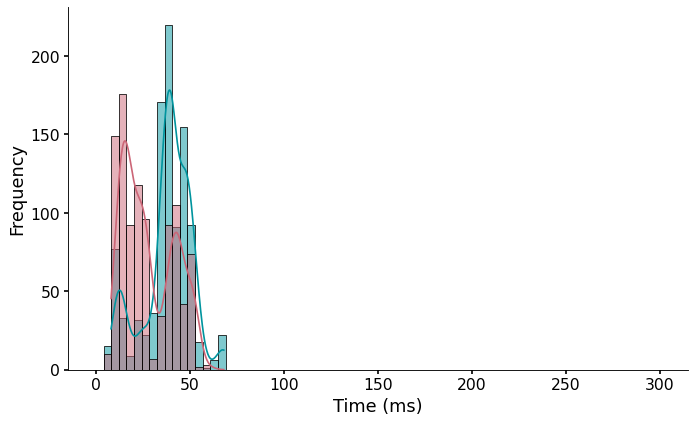

In [34]:



boot_df = pd.read_csv(f'{results_dir}/erp/onset_boot_df.csv')
melt_boot = boot_df.melt(var_name='roi', value_name='onset')
melt_boot['roi'] = melt_boot['roi'].replace({'dorsal':'Dorsal','ventral':'Ventral'})

colors = ['#00949e','#CC6677']
colors = ['#CC6677','#00949e']
plt.figure(figsize=(10, 6), dpi=80)
sns.histplot(data=melt_boot, x = 'onset', binrange = [0,300], bins= 74,hue='roi', legend = False, palette=colors,kde = True, alpha = .5)


#sns.move_legend(ax, "upper right",fontsize=16)
ax.set(
    xlim=(-30, 300),
    
)
#ax.set_xticklabels(fontsize=14)
#ax.set_yticklabels(fontsize=14)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
#ax.set_axis_labels(fontsize=16)
#ax.set_xlabels("Time (ms)",fontsize=16)
#ax.set_ylabels("Frequency",fontsize=16)


plt.xlabel('Time (ms)',fontsize=16)
plt.ylabel('Frequency',fontsize=16)

plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
#plt.ylim(-.5,3.8)

ax = plt.gca()
ax.xaxis.set_tick_params(width=1.5)
ax.yaxis.set_tick_params(width=1.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.ax.tick_params(width=1.5)


plt.savefig(f'{fig_dir}/erp_onset_histogram.png', dpi=300)


#### Main decoding plots

In [75]:
"""
Calc bootstrap CIs
"""

rois = ['dorsal','ventral']
iter = 10000
alpha = .05

boot_df = pd.DataFrame()
for roi in rois:
    decoding_data = np.load(f'{results_dir}/decode/{roi}_decoding.npy')
    decoding_data = decoding_data[:,stim_onset:]
    decoding_data = pd.DataFrame(decoding_data) #convert to dataframe because it has a good resampling function
    decode_boot = []
    sub_counts = np.zeros((1,decoding_data.shape[1]))

    
    for ii in range(0,iter):
        #resample the sub decode data with replacement
        sub_sample = decoding_data.sample(decoding_data.shape[0],replace = True, random_state=ii)
        
        #convert it back to a numpy array
        sub_sample = sub_sample.to_numpy() 

        #calculate the bootstrap sample mean
        decode_boot.append(np.mean(sub_sample, axis = 0))

    decode_boot = np.asanyarray(decode_boot)
    decode_cis = np.zeros((3,decode_boot.shape[1]))
    for time in range(0,decode_boot.shape[1]):
        #plot the difference values with confidence intervals
        
        ci_low = np.percentile(decode_boot[:,time], alpha*100)
        ci_high= np.percentile(decode_boot[:,time], 100-alpha*100)
        if ci_low >= 0:
            sig = 1
        else:
            sig = 0

        decode_cis[0,time] = ci_low
        decode_cis[1,time] = ci_high
        decode_cis[2,time] = sig

        


        

In [74]:
decode_cis

array([[0.22682812, 0.21964062, 0.2215625 , 0.21464063, 0.20717188,
        0.20123437, 0.20967187, 0.23204688, 0.22434375, 0.2174375 ,
        0.21023437, 0.21360937, 0.21051563, 0.21090625, 0.20870312,
        0.216625  , 0.22557813, 0.22559375, 0.21453125, 0.22779687,
        0.26342187, 0.23735937, 0.22835938, 0.24145312, 0.27048437,
        0.2804375 , 0.27454687, 0.24170312, 0.23807812, 0.24395312,
        0.2468125 , 0.25682813, 0.2614375 , 0.2593125 , 0.26801562,
        0.26354687, 0.26810937, 0.27498438, 0.27873437, 0.283125  ,
        0.2721875 , 0.26959375, 0.27059375, 0.27120312, 0.286875  ,
        0.2945    , 0.291125  , 0.28651562, 0.27842187, 0.29717187,
        0.31828125, 0.31953125, 0.3185625 , 0.3099375 , 0.308375  ,
        0.3111875 , 0.29425   , 0.30628125, 0.30810937, 0.31554688,
        0.30609375, 0.3086875 , 0.31246875, 0.29459375, 0.29125   ,
        0.306875  , 0.30882812, 0.27826562, 0.2840625 , 0.29026562,
        0.29739063, 0.285625  , 0.2735    , 0.27

(0, 'dorsal') max time: 210
(1, 'ventral') max time: 214


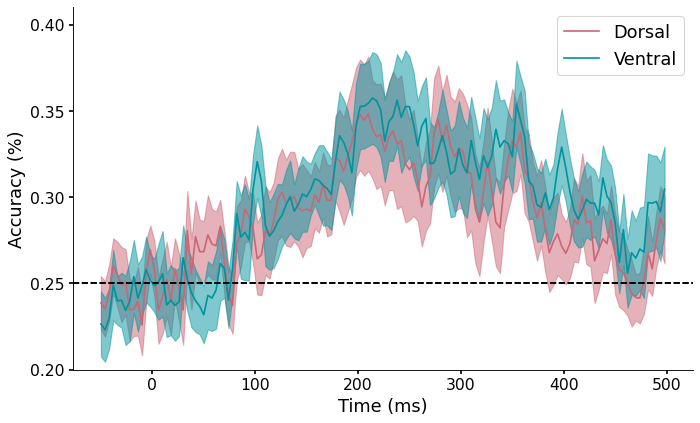

In [29]:
'''
Plot decodeing accuracy for each ROI with shading
'''
rois = ['ventral', 'dorsal']
roi_names = ['Ventral', 'Dorsal']
colors = ['#CC6677','#00949e']

rois = ['dorsal', 'ventral']
#colors = ['#00949e','#CC6677']
onsets = [66,82]



plt.figure(figsize=(10, 6), dpi=80)
for roi in enumerate(rois):
    roi_decoding = np.load(f'{results_dir}/decode/{roi[1]}_decoding.npy')
    roi_mean = np.mean(roi_decoding, axis=0)
    maxtime = np.where(roi_mean == np.max(roi_mean))[0][0]
    print(f'{roi} max time:', ((maxtime *bin_length)-start_window))
    
    sem = np.std(roi_decoding, ddof=1, axis =0) / np.sqrt(roi_decoding.shape[0])

    plt.plot(timepoints, roi_mean, label=roi[1].capitalize(), color = colors[roi[0]]) #...plot the data, add error bars to mat plot lib, use standard error of the mean to add., there is a package called psypy to do this (psyplot - SEM)
    plt.axhline(y=0.25, color='k', linestyle='--')
    
    #plt.axhline(y=0.2215, color='k', linestyle='--')
    plt.fill_between(timepoints, roi_mean-sem, roi_mean+sem,alpha=0.5, color = colors[roi[0]])
    plt.legend(fontsize=16)

    plt.xlabel('Time (ms)',fontsize=16)
    plt.ylabel('Accuracy (%)',fontsize=16)
    #plt.axvline(onsets[roi[0]],  linestyle='--', color = colors[roi[0]])
    #plt.yticks(np.arange(min(x), max(x)+1, 1.0))
    plt.xticks(fontsize= 14)
    plt.yticks(fontsize= 14)
    plt.ylim(.2,.41)

    ax = plt.gca()
    ax.xaxis.set_tick_params(width=1.5)
    ax.yaxis.set_tick_params(width=1.5)

    start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(start, end, .05))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    #plt.show()
    
    plt.savefig(f'{fig_dir}/decoding_plot.png', dpi=300)


#### Decoding significance across time

In [35]:

rois = ['dorsal','ventral']
for roi in rois:
    decoding_data = np.load(f'{results_dir}/decode/{roi}_decoding.npy')
    sig_ts = []
    for time in range(0, decoding_data.shape[1]):
        p_val = stats.ttest_1samp((decoding_data[:,time]), .25, axis = 0, alternative='greater')
        sig_ts.append(p_val[1])

    np.save(f'{results_dir}/decode/{roi}_sig_ts.npy', sig_ts)

(0, 'dorsal') 66
(1, 'ventral') 82


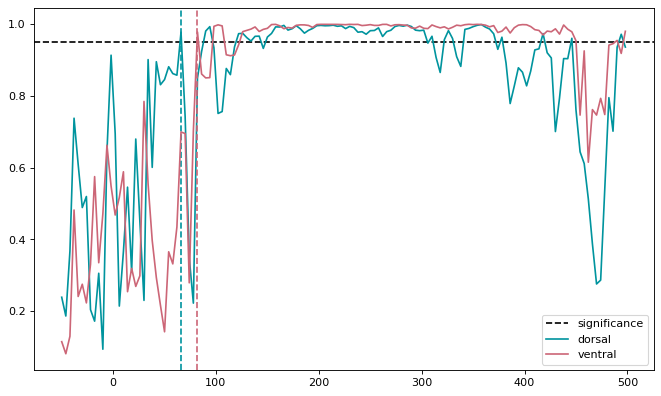

In [36]:
'''
Plot significance time series
'''

rois = ['dorsal','ventral']
line_color = ['#00949e','#CC6677']
alpha_level = .95
plt.figure(figsize=(10, 6), dpi=80)
plt.axhline(alpha_level, color = 'k', label='significance', linestyle='--')
for roi in enumerate(rois):
    sig_data = 1-np.load(f'{results_dir}/decode/{roi[1]}_sig_ts.npy')
    onset = np.min(np.where(sig_data >= alpha_level))
    onset = (onset *bin_length)-start_window
    plt.plot(timepoints, sig_data, label = roi[1], color = line_color[roi[0]])
    plt.axvline(onset,  linestyle='--', color = line_color[roi[0]])
    plt.legend()
    print(roi, onset)





#### Test significant decoding onset

In [37]:
'''
Boot strap participant data and extract onset
'''

rois = ['dorsal','ventral']
iter = 1000

boot_df = pd.DataFrame()
for roi in rois:
    decoding_data = np.load(f'{results_dir}/decode/{roi}_decoding.npy')
    decoding_data = decoding_data[:,stim_onset:]
    decoding_data = pd.DataFrame(decoding_data) #convert to dataframe because it has a good resampling function
    decode_boot = []
    sub_counts = np.zeros((1,decoding_data.shape[1]))

    for ii in range(0,iter):
        
        #resample the sub decode data with replacement
        sub_sample = decoding_data.sample(decoding_data.shape[0],replace = True, random_state=ii)
        
        #convert it back to a numpy array
        sub_sample = sub_sample.to_numpy() 
        
        #calculate the bootstrap sample mean
        sig_boot = []
        
        #only add values if they are significant two timepoints in arow
        sig_consistent = []
        
        sig_ts = []
        for time in range(0,sub_sample.shape[1]):
            p_val= stats.ttest_1samp(sub_sample[:,time], .25, axis = 0, alternative='greater')
            
            #append the p-value for every time point
            sig_ts.append(p_val[1])  


            #mark timepoints that are above chance for at least two timepoints in a row
            if time > 0:

                if sig_ts[time] <= .05 and sig_ts[time-1] <=.05:
                    sig_consistent.append(1)
                else:
                    sig_consistent.append(0)

        #reconvert p-value list into a numpy array
        sig_ts = np.asanyarray(sig_ts)

        #reconvert consistent list into a numpy array
        sig_consistent = np.asanyarray(sig_consistent)
            
        #find the the first time point that is below change (0.05)
        #np.where simply returns the indices (i.e., spots in an array), that meet some condition
        #i'm simply grabbing the first value of that list, which corresponds to the first time point above chance
        try:
            sig_onset = np.where(sig_consistent ==1,)[0][0]
        except:
            sig_onset= decoding_data.shape[1]
        
        
        
        sub_counts[0,np.where(sig_ts <=.05)[0]] += 1
        
        #if d_onset == 1:
        #    pdb.set_trace()
        
        #convert to the actual time point
        sig_onset = (sig_onset *4)

        #add the onset value from the resample to a list
        decode_boot.append(sig_onset)
    
    boot_df[roi] = decode_boot

boot_df.to_csv(f'{results_dir}/decode/onset_boot_df.csv',index= False)

In [38]:
'''
Run binomial test on bootstrapped data
'''

comparisons = [['dorsal','ventral'] ]

for roi in comparisons:
    #Calcualte the time  difference for each bootstrap between roi pairs
    diff = boot_df[roi[0]] - boot_df[roi[1]]

    #count the number of times the first roi precedes the other
    time_count = np.sum(diff < 0)

    print('p val', stats.binom_test(time_count,n=len(diff), p= 0.5, alternative='two-sided'))
    print('count of diffs', time_count)
    print('mean diff', np.mean(diff))



p val 5.249291116750507e-27
count of diffs 669
mean diff -15.952


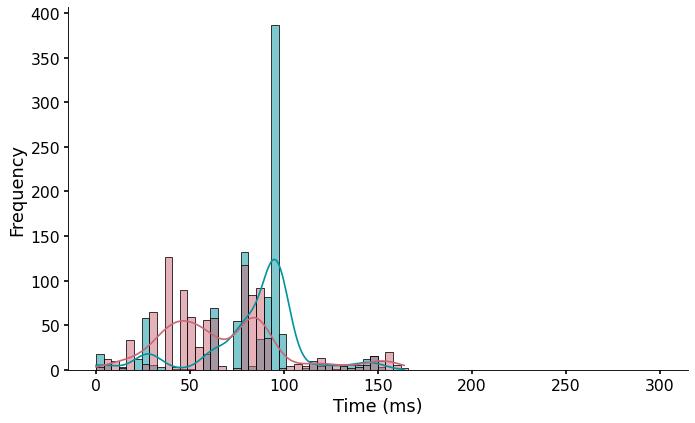

In [33]:
"""Decoding onset histogram"""


boot_df = pd.read_csv(f'{results_dir}/onsets/onset_boot_df.csv')
boot_df = boot_df.drop(columns = ['Unnamed: 0'])
melt_boot = boot_df.melt(var_name='roi', value_name='onset')
melt_boot['roi'] = melt_boot['roi'].replace({'dorsal':'Dorsal','ventral':'Ventral'})

colors = ['#00949e','#CC6677']
colors = ['#CC6677','#00949e']
plt.figure(figsize=(10, 6), dpi=80)
sns.histplot(data=melt_boot, x = 'onset', binrange = [0,300], bins= 74,hue='roi', legend = False, palette=colors,kde = True, alpha = .5)


#sns.move_legend(ax, "upper right",fontsize=16)
ax.set(
    xlim=(-30, 300),
    
)
#ax.set_xticklabels(fontsize=14)
#ax.set_yticklabels(fontsize=14)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
#ax.set_axis_labels(fontsize=16)
#ax.set_xlabels("Time (ms)",fontsize=16)
#ax.set_ylabels("Frequency",fontsize=16)


plt.xlabel('Time (ms)',fontsize=16)
plt.ylabel('Frequency',fontsize=16)

plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
#plt.ylim(-.5,3.8)

ax = plt.gca()
ax.xaxis.set_tick_params(width=1.5)
ax.yaxis.set_tick_params(width=1.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.ax.tick_params(width=1.5)


plt.savefig(f'{fig_dir}/decoding_onset_histogram.png', dpi=300)



#### Granger causality

In [23]:
gca = pd.read_csv(f'{results_dir}/mvgca/mvgca_summary.csv')

<AxesSubplot:ylabel='dorsal_ventral'>

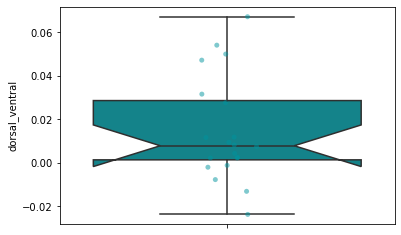

In [25]:
sns.boxplot(y=gca['dorsal_ventral'], color = '#00949e', notch=True)
 
# make grouped stripplot
sns.stripplot(y=gca['dorsal_ventral'], color = '#00949e',
              marker='o', 
              alpha=0.5)

#### Time generalized RSA analyses

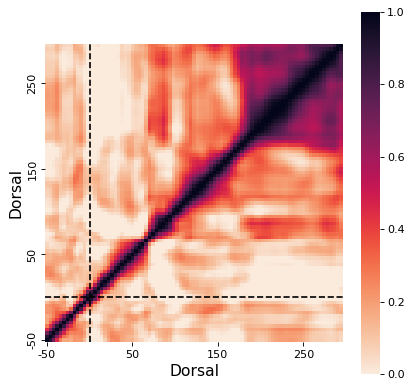

<Figure size 432x288 with 0 Axes>

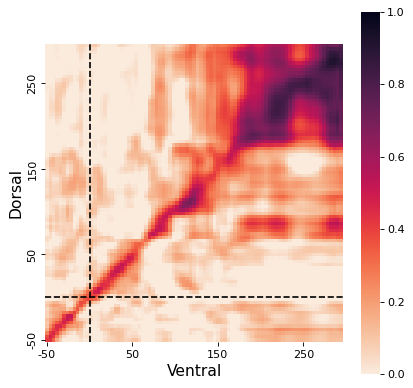

<Figure size 432x288 with 0 Axes>

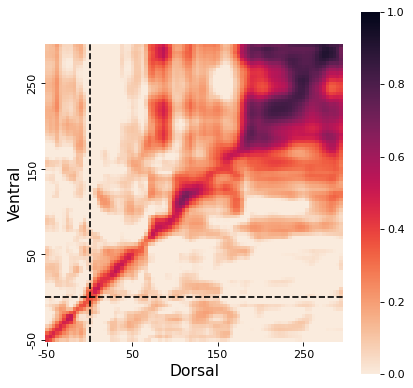

<Figure size 432x288 with 0 Axes>

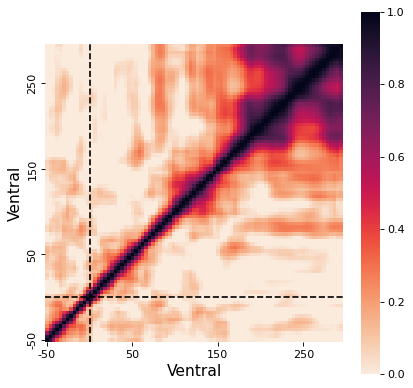

<Figure size 432x288 with 0 Axes>

In [54]:
"""
Plot time generalization using mean RDMs
"""

rois = ['dorsal','ventral']
#rois = ['dorsal']

#timepoints = np.asanyarray(timepoints)
time_cols = np.asanyarray(timepoints)
time_cols[1:] = time_cols[1:]
for roi1 in rois:
    for roi2 in rois:
        plt.figure(figsize=(6, 6), dpi=80)
        corr_ts = np.load(f'{results_dir}/rsa/{roi1}_{roi2}_corr_ts.npy')
        
        corr_df = pd.DataFrame(corr_ts, columns = time_cols, index = time_cols)
        corr_df = corr_df.iloc[:stim_offset,:stim_offset]
        ax = sns.heatmap(corr_df,xticklabels=25,yticklabels=25, vmin = 0, vmax = 1, square = True,
            cmap= "rocket_r")
        #ax.set_title(f'{roi1} {roi2}')
        ax.invert_yaxis()
        plt.axvline(13,  linestyle='--', color = 'black')
        plt.axhline(13,  linestyle='--', color = 'black')
        plt.ylabel(roi1.capitalize(), fontsize=14)
        plt.xlabel(roi2.capitalize(), fontsize=14)
        #cbar = ax.collections[0].colorbar
        #cbar.ax.tick_params(labelsize=12)
        #cbar.ax.clabel

        #ax.set(xticklabels=[])

        #ax.tick_params(bottom=False)  # remove the ticks
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.show()
        plt.savefig(f'{fig_dir}/{roi1}_{roi2}_time_generalization.png', dpi=300)
    

In [56]:
"""
Time generalization diff on mean RDMs
"""

corr_ts = np.load(f'{results_dir}/rsa/dorsal_ventral_corr_ts.npy')
corr_ts = corr_ts[stim_onset:stim_offset,stim_onset:stim_offset]

corr_df = pd.DataFrame()
corr_df['corrs'] = corr_ts.flatten()

x_coord = []
y_coord = []
offset = []
label = []

inds = np.triu_indices(n=corr_ts.shape[0],k=1)
right_side = corr_ts[inds] #extract lower triangle
left_side = corr_ts[(inds[1],inds[0])] #extract upper triangle

for corr in corr_df['corrs']:
    if len(np.where(right_side == corr)[0]) == 1:
        label.append('Dorsal')
    if len(np.where(left_side == corr)[0]) == 1:
        label.append('Ventral')
    elif len(np.where(right_side == corr)[0]) == 0 and len(np.where(left_side == corr)[0]) == 0:
        label.append('Same')
    

    curr_x = np.where(corr_ts == corr)[0]
    curr_y = np.where(corr_ts == corr)[1]
    x_coord.append(curr_x)
    y_coord.append(curr_y)

    offset.append((curr_x- curr_y)*4)

corr_df['x_coord'] = x_coord
corr_df['y_coord'] = y_coord
corr_df['offset'] = offset
corr_df['label'] = label

corr_df.to_csv(f'{results_dir}/rsa/dorsal_ventral_corrs.csv')

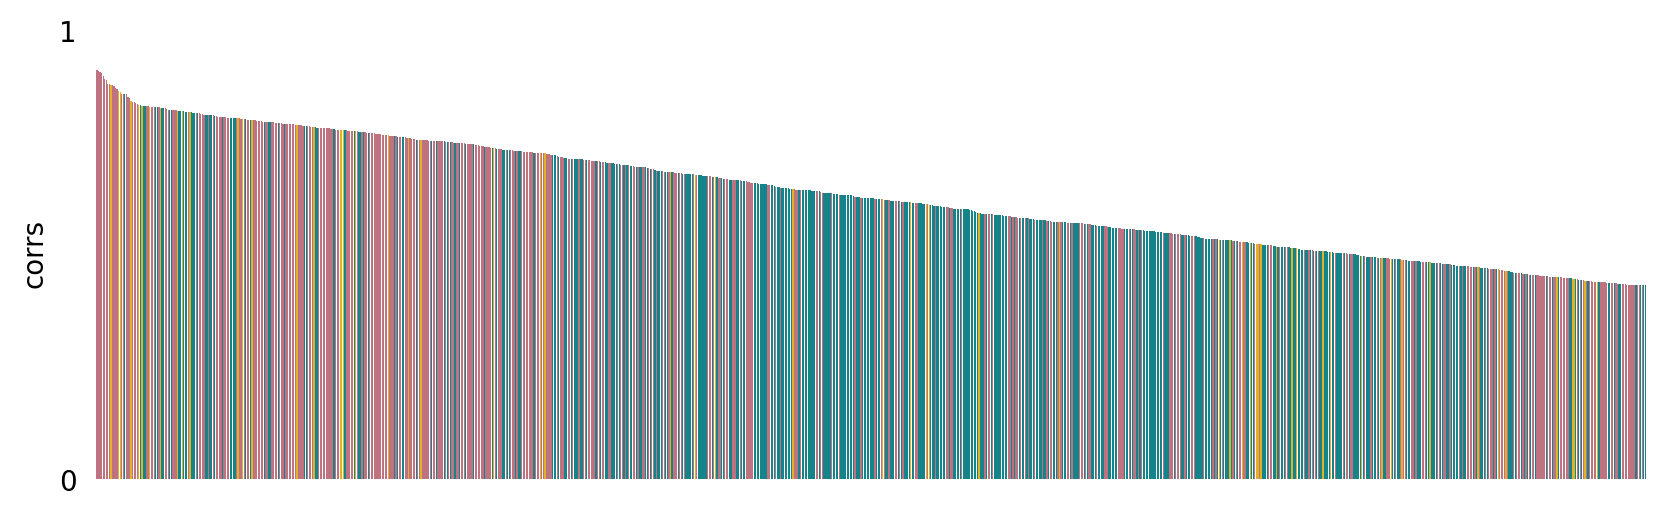

In [61]:
corr_df = pd.read_csv(f'{results_dir}/rsa/dorsal_ventral_corrs.csv')
corr_df.to_csv(f'{results_dir}/rsa/dorsal_ventral_corrs.csv')
corr_df = corr_df.sort_values(by='corrs', ascending=False)
corr_df = corr_df.reset_index()

vals = 1000
fig_df = corr_df.head(vals)

plt.figure(figsize=(10, 3), dpi=200)
sns.barplot(y=fig_df['corrs'], x = fig_df.index,order = fig_df.index, hue = fig_df['label'],dodge = False,
            palette = ['#CC6677','#FFC107','#00949e'])
ax = plt.gca()
ax.set(xticklabels=[])
ax.tick_params(bottom=False,left= False)  # remove the ticks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)


#plt.ylabel('Correlation',fontsize=16)
#plt.axvline(onsets[roi[0]],  linestyle='--', color = colors[roi[0]])
#plt.yticks(np.arange(min(x), max(x)+1, 1.0))
#plt.xticks(fontsize= 14)
#plt.yticks(fontsize= 14)
plt.ylim(0,1.01)

ax = plt.gca()
#ax.xaxis.set_tick_params(width=1.5)
#ax.yaxis.set_tick_params(width=1.5)

start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(start, end, 1))

ax.get_legend().remove()


plt.savefig(f'{fig_dir}/correlation_hist_{vals}.png', dpi=300)

In [72]:
vals = np.arange(50,2050,50)

for val in vals:
    fig_df = corr_df.head(val)

    time_count = np.sum(fig_df['label'] == 'Dorsal')

    print(f'{time_count} out of {val}', time_count/ val, stats.binom_test(time_count,n=val, p= 0.49, alternative='two-sided'))
    

32 out of 50 0.64 0.04657324328729136
56 out of 100 0.56 0.16316538917791495
94 out of 150 0.6266666666666667 0.0010211600934461654
128 out of 200 0.64 2.64399695568903e-05
166 out of 250 0.664 3.9282067591700065e-08
198 out of 300 0.66 3.914506101385884e-09
225 out of 350 0.6428571428571429 1.1284876900573319e-08
246 out of 400 0.615 6.502273279660454e-07
264 out of 450 0.5866666666666667 4.7702337166306036e-05
276 out of 500 0.552 0.006304786666892036
290 out of 550 0.5272727272727272 0.08792586023797154
304 out of 600 0.5066666666666667 0.4145212516445828
322 out of 650 0.49538461538461537 0.7837910123656295
342 out of 700 0.48857142857142855 0.9698475413974452
357 out of 750 0.476 0.4651427596444704
370 out of 800 0.4625 0.12831207041056875
388 out of 850 0.45647058823529413 0.05059740283849208
408 out of 900 0.4533333333333333 0.02780474265606428
441 out of 950 0.46421052631578946 0.1192729863728948
471 out of 1000 0.471 0.24187508441043565
494 out of 1050 0.4704761904761905 0.216

In [68]:
"""
Test whether **MEAN** RDMs are right shifted or left shifted
"""
rois = ['dorsal','ventral']


#timepoints = np.asanyarray(timepoints)
time_cols = np.asanyarray(timepoints)
time_cols[1:] = time_cols[1:] + 2
df = pd.DataFrame()
for roi1 in rois:
    for roi2 in rois:
        if roi1 == roi2:
            continue
        else:
            corr_ts = np.load(f'{results_dir}/rsa/{roi1}_{roi2}_corr_ts.npy')
            corr_ts = corr_ts[stim_onset:stim_offset,stim_onset:stim_offset]

            #extract left and right sides of the diagnol
            inds = np.triu_indices(n=corr_ts.shape[0],k=1)
            right_side = corr_ts[inds] #extract lower triangle
            left_side = corr_ts[(inds[1],inds[0])] #extract upper triangle

            #calculate the difference between the left and right sides
            #if positive, then right shifted
            diff = right_side - left_side


            df[f'{roi1}_{roi2}'] = diff
            #left side rdm


df.to_csv(f'{results_dir}/rsa/mean_tga_diffs.csv', index = False)

In [70]:
np.mean(df['dorsal_ventral'])

0.01496259271891622

<AxesSubplot:>

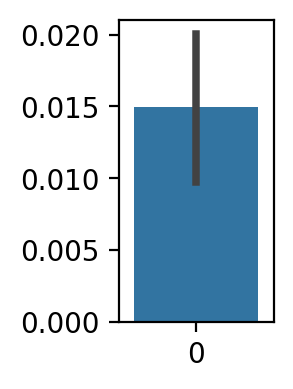

In [69]:


plt.figure(figsize=(1, 2), dpi=200)
sns.barplot(data = df['dorsal_ventral'])
#sns.violinplot(data = df['dorsal_ventral'], jitter=True, size=2, color='black')

In [71]:
"""
Test whether **INDIV** RDMs are right shifted or left shifted
"""
rois = ['dorsal','ventral']


#timepoints = np.asanyarray(timepoints)
time_cols = np.asanyarray(timepoints)
time_cols[1:] = time_cols[1:] + 2



df = pd.DataFrame()
df['subs'] = sub_list
for roi1 in rois:
    for roi2 in rois:
        if roi1 == roi2:
            continue
        else:
            sub_diffs =[]
            for sub in sub_list:
                corr_ts = np.load(f'{data_dir}/{sub}_{roi1}_{roi2}_corr_ts.npy')
                corr_ts = corr_ts[stim_onset:stim_offset,stim_onset:stim_offset]

                #extract left and right sides of the diagnol
                inds = np.triu_indices(n=corr_ts.shape[0],k=1)
                right_side = corr_ts[inds] #extract lower triangle
                left_side = corr_ts[(inds[1],inds[0])] #extract upper triangle

                #calculate the difference between the left and right sides
                #if positive, then right shifted
                diff = right_side - left_side


                
                #left side rdm

                sub_diffs.append(np.mean(diff))

            df[f'{roi1}_{roi2}'] = sub_diffs


df.to_csv(f'{results_dir}/rsa/indiv_tga_diffs.csv', index = False)